In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyscf import scf, gto, cc
from ase.io import read, write
from ase.units import Hartree, mol, kcal
from pylibnxc.pyscf import UKS
from dpyscfl.utils import gen_mf_mol, ase_atoms_to_mol
from ase import Atoms
from opt_einsum import contract
import torch
import pickle
kcal_mol = kcal/mol
kcal_mol
Hart_to_kcalmol = Hartree/kcal_mol
figp = '/home/awills/Documents/Research/figs/ml'

In [4]:
def read_eval_table_only(path):
    tab=pd.read_csv(path, delimiter='\t')
    return tab

def read_eval_table(path, epred = 2, eref = 3, aepred = 5, aeref = 6,
                   aerefmult = -1, scale=1, skipinds = None, mae=False):
    tab = pd.read_csv(path, delimiter = '\t').replace('nan', -100000)
    tab.columns = [i.strip() for i in tab.columns]
    tcol = tab.columns
    print(tab)
    aey = scale*tab[tcol[aepred]].astype(np.float64).values
    ey = scale*tab[tcol[epred]].astype(np.float64).values
    
    erefv = scale*tab[tcol[eref]].values
    aerefv = scale*tab[tcol[aeref]].values
    
    if skipinds:
        aey = np.array([aey[i] for i in range(len(aey)) if i not in skipinds])
        ey = np.array([ey[i] for i in range(len(ey)) if i not in skipinds])
        erefv = np.array([erefv[i] for i in range(len(erefv)) if i not in skipinds])
        aerefv = np.array([aerefv[i] for i in range(len(aerefv)) if i not in skipinds])
    if mae:
        e_err = np.mean( np.abs( ey - erefv) )
        ae_err = np.mean( np.abs( aey - (aerefmult*aerefv) ) )
    else:
        e_err = np.mean( np.sqrt( (ey - erefv)**2 ) )
        ae_err = np.mean( np.sqrt( (aey - (aerefmult*aerefv) )**2 ) )
    
    return (tab, ey, aey, e_err, ae_err)

def get_spin(at):
    #if single atom and spin is not specified in at.info dictionary, use spins_dict
    print('======================')
    print("GET SPIN: Atoms Info")
    print(at)
    print(at.info)
    print('======================')
    if ( (len(at.positions) == 1) and not ('spin' in at.info) ):
        print("Single atom and no spin specified in at.info")
        spin = spins_dict[str(at.symbols)]
    else:
        print("Not a single atom, or spin in at.info")
        if type(at.info.get('spin', None)) == type(0):
            #integer specified in at.info['spin'], so use it
            print('Spin specified in atom info.')
            spin = at.info['spin']
        elif 'radical' in at.info.get('name', ''):
            print('Radical specified in atom.info["name"], assuming spin 1.')
            spin = 1
        elif at.info.get('openshell', None):
            print("Openshell specified in atom info, attempting spin 2.")
            spin = 2
        else:
            print("No specifications in atom info to help, assuming no spin.")
            spin = 0
    return spin

def gen_pltaxs(figsize=(18,18), scale=1):
    f = plt.figure(figsize=figsize)
    eax = f.add_subplot(221)
    dax = f.add_subplot(223)

    edax = f.add_subplot(222)
    ddax = f.add_subplot(224)

    dax.grid()
    ddax.grid()
    eax.grid()
    edax.grid()

    if scale == Hart_to_kcalmol:
        units = 'kcal/mol'
    else:
        units = 'H'

    eax.set_xlabel("Literature Reference\nAtomization Energy ({})".format(units),fontsize=14)
    eax.set_ylabel('Predicted\nAtomization Energy ({})'.format(units), fontsize=14)
    edax.set_ylabel('AE Energy Deviation', fontsize=14)
    edax.set_xlabel('Dataset Index', fontsize=14)

    
    dax.set_xlabel('CCSD(T) Energy ({})'.format(units), fontsize=14)
    dax.set_ylabel('Predicted Total Energy ({})'.format(units), fontsize=14)
    ddax.set_xlabel('Dataset Index', fontsize=14)
    ddax.set_ylabel('Total Energy Deviation', fontsize=14)

    #ddax.set_ylim(-1*scale, 1*scale)
    
    return (f, eax, edax, dax, ddax)

def gen_rhoaxs(figsize=(9,9), scale=1):
    f = plt.figure(figsize=figsize)
    ax = f.add_subplot(111)
    ax.grid()
    
    units = 'e'
    
    ax.set_xlabel('Dataset Index', fontsize=14)
    ax.set_ylabel('Rho Loss', fontsize=14)
    
    return (f, ax)

def plot_e_dev(enax, endax, refs, reflabel, datlist):
    z = np.zeros_like(refs)
    i = np.arange(len(refs))
    enax.plot(refs, refs, 'k-', label=reflabel)
    endax.plot(np.zeros_like(refs), 'k--')
    for arg in datlist:
        enax.scatter(refs, arg[0], label=arg[1])
        endax.plot(np.array(arg[0]) - np.array(refs), label=arg[1])
        
def bhcalc(tab, bhinds, reftraj):
    bhps = []
    for i in bhinds:
        e = 0
        for j in i:
            et = reftraj[j].info['enmult']*tab.iloc[j, 2].astype(np.float64)
            e += et
        bhps.append(e)
    return bhps

def split(el):
    """Regex split molecule's symbolic expansion into constituent elements.
    No numbers must be present -- CH2 = CHH.

    Args:
        el (str): Molecule symbols

    Returns:
        list: list of individual atoms in molecule
    """
    import re
    res_list = [s for s in re.split("([A-Z][^A-Z]*)", el) if s]
    return res_list


def dm_to_rho(dm, ao_eval):
    if len(dm.shape) == 2:
        print("2D DM.")
        rho = contract('ij,ik,jk->i',
                           ao_eval, ao_eval, dm)
    else:
        print("NON-2D DM")
        rho = contract('ij,ik,xjk->xi',
                           ao_eval, ao_eval, dm)
    return rho

def rho_dev(dm, nelec, rho, rho_ref, grid_weights, mo_occ):
    mo_occ = torch.Tensor(mo_occ)
    if len(dm.shape) == 2:
        print("2D DM.")
        drho = torch.sqrt(torch.sum(torch.Tensor((rho-rho_ref)**2*grid_weights)/nelec**2))
        if torch.isnan(drho):
            print("NAN IN RHO LOSS. SETTING DRHO ZERO.")
            drho = torch.Tensor([0])
    else:
        print("NON-2D DM")
        if torch.sum(mo_occ) == 1:
            drho = torch.sqrt(torch.sum(torch.Tensor((rho[0]-rho_ref[0])**2*grid_weights)/torch.sum(mo_occ[0,0])**2))
        else:
            drho = torch.sqrt(torch.sum(torch.Tensor((rho[0]-rho_ref[0])**2*grid_weights))/torch.sum(mo_occ[0,0])**2 +\
                   torch.sum(torch.Tensor((rho[1]-rho_ref[1])**2*grid_weights))/torch.sum(mo_occ[0,1])**2)
        if torch.isnan(drho):
            print("NAN IN RHO LOSS. SETTING DRHO ZERO.")
            drho = torch.Tensor([0])
    return drho


0
/home/awills/Documents/Research/swxcd/scont_aegis/target
['MODEL_GGA_e00', 'MODEL_GGA_e01', 'MODEL_GGA_e02', 'MODEL_GGA_e03', 'MODEL_GGA_e04', 'MODEL_GGA_e05', 'MODEL_GGA_e06', 'MODEL_GGA_e07', 'MODEL_GGA_e08', 'MODEL_GGA_e09', 'MODEL_GGA_e10', 'MODEL_GGA_e11', 'MODEL_GGA_e12', 'MODEL_GGA_e13', 'MODEL_GGA_e14', 'MODEL_GGA_e15', 'MODEL_GGA_e16', 'MODEL_GGA_e17', 'MODEL_GGA_e18', 'MODEL_GGA_e19', 'MODEL_GGA_e20', 'MODEL_GGA_e21', 'MODEL_GGA_e22', 'MODEL_GGA_e24', 'MODEL_GGA_e25', 'MODEL_GGA_e26', 'MODEL_GGA_e27', 'MODEL_GGA_e28', 'MODEL_GGA_e29', 'MODEL_GGA_e30', 'MODEL_GGA_e31', 'MODEL_GGA_e32', 'MODEL_GGA_e34', 'MODEL_GGA_e35', 'MODEL_GGA_e37', 'MODEL_GGA_e39', 'MODEL_GGA_e41', 'MODEL_GGA_e42', 'MODEL_GGA_e43', 'MODEL_GGA_e45', 'MODEL_GGA_e47', 'MODEL_GGA_e50', 'MODEL_GGA_e51', 'MODEL_GGA_e54', 'MODEL_GGA_e60', 'MODEL_GGA_e72', 'MODEL_GGA_e74', 'MODEL_GGA_e78', 'MODEL_GGA_e82', 'MODEL_GGA_e91', 'MODEL_GGA_e93', 'MODEL_GGA_e96']
C -37.50172812528448
H -0.4830359902131694
Li -7.3602676

RuntimeError. Trying with reduced spin.
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.23152900416628}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.23152900416628}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Building grids...
Grid level = 5
Grid coordinate shape: (86680, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (86680, 78)
dm_pred:  (2, 78, 78)
dm_ref:  (2, 7

SHAPES
ao_eval:  (175984, 156)
dm_pred:  (2, 156, 156)
dm_ref:  (2, 156, 156)
NON-2D DM
NON-2D DM
NON-2D DM
0 Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -323.5511349803161}
['B', 'F', 'F', 'F']
----------------------------------
BFFF B
BFFF F
BFFF F
BFFF F
ae en: -417.03489155667194
ref en: -471.3910133843212
abs err: 54.35612182764925
rho err: 0.03647841885685921
BHS:  [[-407.54851087182965, -469.8321599711635], [-397.83513133763785, -443.863396077606], [-388.47406772187384, -417.03489155667194]]
N -54.51952062187797
F -99.56940667577554
H -0.5060119494190449
Li -7.495761711009039
C -37.817677648329735
O -74.96227888502433
B -24.65476480472185
Atoms(symbols='LiH', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='LiH', pbc=False, calculator=SinglePointCalculator(...))
{'LiH': True, 'name': 'Lithi

RuntimeError. Trying with reduced spin.
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.84411086984105}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.84411086984105}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Building grids...
Grid level = 5
Grid coordinate shape: (86680, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (86680, 78)
dm_pred:  (2, 78, 78)
dm_ref:  (2, 7

SHAPES
ao_eval:  (175984, 156)
dm_pred:  (2, 156, 156)
dm_ref:  (2, 156, 156)
NON-2D DM
NON-2D DM
NON-2D DM
0 Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.3255183560954}
['B', 'F', 'F', 'F']
----------------------------------
BFFF B
BFFF F
BFFF F
BFFF F
ae en: -402.2585464275908
ref en: -471.3910133843212
abs err: 69.13246695673041
rho err: 0.05959001183509827
BHS:  [[-407.54851087182965, -469.8321599711635], [-397.83513133763785, -443.863396077606], [-388.47406772187384, -417.03489155667194], [-383.1297265102766, -401.4251959867688], [-382.1308052957298, -396.89848298228753], [-384.6863487272399, -402.2585464275908]]
N -54.58310349962524
H -0.507918052159505
O -75.0432580425358
F -99.66663670838622
Li -7.511021854708831
B -24.69164618642141
C -37.868342293844535
Atoms(symbols='LiH', pbc=False, calculator=SinglePointCalculator(..

RuntimeError. Trying with reduced spin.
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.87041749816194}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.87041749816194}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Building grids...
Grid level = 5
Grid coordinate shape: (86680, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (86680, 78)
dm_pred:  (2, 78, 78)
dm_ref:  (2, 7

NON-2D DM
NON-2D DM
0 Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
{'C2H2': True, 'name': 'Acetylene', 'openshell': False, 'e_H': 0.6458922998762915, 'e_ev': 17.575624702100136, 'e_pred': -77.35286107025678}
['C', 'C', 'H', 'H']
----------------------------------
CCHH C
CCHH C
CCHH H
CCHH H
ae en: -392.30520710755604
ref en: -405.3035372848948
abs err: 12.998330177338744
rho err: 0.023246141150593758
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.33226267792554}
Not a single atom, or spin in at.info
No specifications in atom info to help, assuming no spin.
Building grids...
Grid level = 5
Grid coordinate shape: (175984, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 

RuntimeError. Trying with reduced spin.
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.8591897011817}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.8591897011817}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Building grids...
Grid level = 5
Grid coordinate shape: (86680, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (86680, 78)
dm_pred:  (2, 78, 78)
dm_ref:  (2, 78,

NON-2D DM
NON-2D DM
0 Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
{'C2H2': True, 'name': 'Acetylene', 'openshell': False, 'e_H': 0.6458922998762915, 'e_ev': 17.575624702100136, 'e_pred': -77.34333788143655}
['C', 'C', 'H', 'H']
----------------------------------
CCHH C
CCHH C
CCHH H
CCHH H
ae en: -398.2611395683041
ref en: -405.3035372848948
abs err: 7.042397716590699
rho err: 0.017235882580280304
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.3480928304519}
Not a single atom, or spin in at.info
No specifications in atom info to help, assuming no spin.
Building grids...
Grid level = 5
Grid coordinate shape: (175984, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7

RuntimeError. Trying with reduced spin.
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.89392998392546}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.89392998392546}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Building grids...
Grid level = 5
Grid coordinate shape: (86680, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (86680, 78)
dm_pred:  (2, 78, 78)
dm_ref:  (2, 7

SHAPES
ao_eval:  (132776, 108)
dm_pred:  (2, 108, 108)
dm_ref:  (2, 108, 108)
NON-2D DM
NON-2D DM
NON-2D DM
0 Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
{'C2H2': True, 'name': 'Acetylene', 'openshell': False, 'e_H': 0.6458922998762915, 'e_ev': 17.575624702100136, 'e_pred': -77.35182173117653}
['C', 'C', 'H', 'H']
----------------------------------
CCHH C
CCHH C
CCHH H
CCHH H
ae en: -403.01744933799296
ref en: -405.3035372848948
abs err: 2.28608794690183
rho err: 0.013776303268969059
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.4102038068882}
Not a single atom, or spin in at.info
No specifications in atom info to help, assuming no spin.
Building grids...
Grid level = 5
Grid coordinate shape: (175984, 3)
METHOD G

RuntimeError. Trying with reduced spin.
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.86045434557238}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.86045434557238}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Building grids...
Grid level = 5
Grid coordinate shape: (86680, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (86680, 78)
dm_pred:  (2, 78, 78)
dm_ref:  (2, 7

Grid coordinate shape: (132776, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (132776, 108)
dm_pred:  (2, 108, 108)
dm_ref:  (2, 108, 108)
NON-2D DM
NON-2D DM
NON-2D DM
0 Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
{'C2H2': True, 'name': 'Acetylene', 'openshell': False, 'e_H': 0.6458922998762915, 'e_ev': 17.575624702100136, 'e_pred': -77.36663565573689}
['C', 'C', 'H', 'H']
----------------------------------
CCHH C
CCHH C
CCHH H
CCHH H
ae en: -408.3590266386104
ref en: -405.3035372848948
abs err: 3.0554893537155863
rho err: 0.012997560203075409
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.4897313586471}
Not a single atom, or spin

RuntimeError. Trying with reduced spin.
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.898337910504}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.898337910504}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Building grids...
Grid level = 5
Grid coordinate shape: (86680, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (86680, 78)
dm_pred:  (2, 78, 78)
dm_ref:  (2, 78, 7

Grid coordinate shape: (132776, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (132776, 108)
dm_pred:  (2, 108, 108)
dm_ref:  (2, 108, 108)
NON-2D DM
NON-2D DM
NON-2D DM
0 Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
{'C2H2': True, 'name': 'Acetylene', 'openshell': False, 'e_H': 0.6458922998762915, 'e_ev': 17.575624702100136, 'e_pred': -77.33981498331495}
['C', 'C', 'H', 'H']
----------------------------------
CCHH C
CCHH C
CCHH H
CCHH H
ae en: -415.4408971173641
ref en: -405.3035372848948
abs err: 10.137359832469315
rho err: 0.014866471290588379
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.46462327913173}
Not a single atom, or spi

RuntimeError. Trying with reduced spin.
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.89878019803325}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.89878019803325}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Building grids...
Grid level = 5
Grid coordinate shape: (86680, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (86680, 78)
dm_pred:  (2, 78, 78)
dm_ref:  (2, 7

Building grids...
Grid level = 5
Grid coordinate shape: (132776, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (132776, 108)
dm_pred:  (2, 108, 108)
dm_ref:  (2, 108, 108)
NON-2D DM
NON-2D DM
NON-2D DM
0 Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
{'C2H2': True, 'name': 'Acetylene', 'openshell': False, 'e_H': 0.6458922998762915, 'e_ev': 17.575624702100136, 'e_pred': -77.36719505685045}
['C', 'C', 'H', 'H']
----------------------------------
CCHH C
CCHH C
CCHH H
CCHH H
ae en: -425.33804737210903
ref en: -405.3035372848948
abs err: 20.034510087214244
rho err: 0.019812513142824173
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.5888366

RuntimeError. Trying with reduced spin.
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.9080108179687}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.9080108179687}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Building grids...
Grid level = 5
Grid coordinate shape: (86680, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (86680, 78)
dm_pred:  (2, 78, 78)
dm_ref:  (2, 78,

SHAPES
ao_eval:  (132776, 108)
dm_pred:  (2, 108, 108)
dm_ref:  (2, 108, 108)
NON-2D DM
NON-2D DM
NON-2D DM
0 Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
{'C2H2': True, 'name': 'Acetylene', 'openshell': False, 'e_H': 0.6458922998762915, 'e_ev': 17.575624702100136, 'e_pred': -77.34923585529961}
['C', 'C', 'H', 'H']
----------------------------------
CCHH C
CCHH C
CCHH H
CCHH H
ae en: -435.19943709474296
ref en: -405.3035372848948
abs err: 29.895899809848174
rho err: 0.024617210030555725
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.5823786315559}
Not a single atom, or spin in at.info
No specifications in atom info to help, assuming no spin.
Building grids...
Grid level = 5
Grid coordinate shape: (175984, 3)
METHOD

GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.91385132164112}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.91385132164112}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Building grids...
Grid level = 5
Grid coordinate shape: (86680, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (86680, 78)
dm_pred:  (2, 78, 78)
dm_ref:  (2, 78, 78)
NON-2D DM
NON-2D DM
NON-2D DM
0 A

Grid coordinate shape: (132776, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (132776, 108)
dm_pred:  (2, 108, 108)
dm_ref:  (2, 108, 108)
NON-2D DM
NON-2D DM
NON-2D DM
0 Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
{'C2H2': True, 'name': 'Acetylene', 'openshell': False, 'e_H': 0.6458922998762915, 'e_ev': 17.575624702100136, 'e_pred': -77.36311933073276}
['C', 'C', 'H', 'H']
----------------------------------
CCHH C
CCHH C
CCHH H
CCHH H
ae en: -444.159335804344
ref en: -405.3035372848948
abs err: 38.855798519449195
rho err: 0.02825262024998665
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.65295624141675}
Not a single atom, or spin 

NON-2D DM
NON-2D DM
0 Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.6682414976624}
['B', 'F', 'F', 'F']
----------------------------------
BFFF B
BFFF F
BFFF F
BFFF F
ae en: -512.5379823401599
ref en: -471.3910133843212
abs err: 41.14696895583876
rho err: 0.04193922504782677
BHS:  [[-407.54851087182965, -469.8321599711635], [-397.83513133763785, -443.863396077606], [-388.47406772187384, -417.03489155667194], [-383.1297265102766, -401.4251959867688], [-382.1308052957298, -396.89848298228753], [-384.6863487272399, -402.2585464275908], [-387.5201351366904, -408.92806367049343], [-389.8219938484804, -414.88270513914176], [-392.30520710755604, -421.9502044006513], [-394.1721755646049, -426.76790643049753], [-396.0776612698728, -431.32661701072357], [-398.2611395683041, -436.3078848707228], [-399.91108303927655, -439.65365382631717], [-

RuntimeError. Trying with reduced spin.
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.97377089592476}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.97377089592476}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Building grids...
Grid level = 5
Grid coordinate shape: (86680, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (86680, 78)
dm_pred:  (2, 78, 78)
dm_ref:  (2, 7

Grid coordinate shape: (132776, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (132776, 108)
dm_pred:  (2, 108, 108)
dm_ref:  (2, 108, 108)
NON-2D DM
NON-2D DM
NON-2D DM
0 Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
{'C2H2': True, 'name': 'Acetylene', 'openshell': False, 'e_H': 0.6458922998762915, 'e_ev': 17.575624702100136, 'e_pred': -77.35644386780484}
['C', 'C', 'H', 'H']
----------------------------------
CCHH C
CCHH C
CCHH H
CCHH H
ae en: -457.6176551708345
ref en: -405.3035372848948
abs err: 52.31411788593971
rho err: 0.032639943063259125
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.6808631215915}
Not a single atom, or spin 

SHAPES
ao_eval:  (175984, 156)
dm_pred:  (2, 156, 156)
dm_ref:  (2, 156, 156)
NON-2D DM
NON-2D DM
NON-2D DM
0 Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.77602469990427}
['B', 'F', 'F', 'F']
----------------------------------
BFFF B
BFFF F
BFFF F
BFFF F
ae en: -525.2250603957364
ref en: -471.3910133843212
abs err: 53.83404701141518
rho err: 0.04544532671570778
BHS:  [[-407.54851087182965, -469.8321599711635], [-397.83513133763785, -443.863396077606], [-388.47406772187384, -417.03489155667194], [-383.1297265102766, -401.4251959867688], [-382.1308052957298, -396.89848298228753], [-384.6863487272399, -402.2585464275908], [-387.5201351366904, -408.92806367049343], [-389.8219938484804, -414.88270513914176], [-392.30520710755604, -421.9502044006513], [-394.1721755646049, -426.76790643049753], [-396.0776612698728, -431.32661701072357],

RuntimeError. Trying with reduced spin.
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.93579765407642}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.93579765407642}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Building grids...
Grid level = 5
Grid coordinate shape: (86680, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (86680, 78)
dm_pred:  (2, 78, 78)
dm_ref:  (2, 7

NON-2D DM
NON-2D DM
0 Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.96955850010136}
['N', 'O']
----------------------------------
NO N
NO O
ae en: -215.03254023393674
ref en: -152.79158699808795
abs err: 62.24095323584879
rho err: 0.0425134114921093
Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
{'C2H2': True, 'name': 'Acetylene', 'openshell': False, 'e_H': 0.6458922998762915, 'e_ev': 17.575624702100136, 'e_pred': -77.37235255667817}
Not a single atom, or spin in at.info
No specifications in atom info to help, assuming no spin.
Building grids...
Grid level = 5
Grid coordinate shape: (132776, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (13

Grid coordinate shape: (132776, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (132776, 108)
dm_pred:  (2, 108, 108)
dm_ref:  (2, 108, 108)
NON-2D DM
NON-2D DM
NON-2D DM
0 Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
{'C2H2': True, 'name': 'Acetylene', 'openshell': False, 'e_H': 0.6458922998762915, 'e_ev': 17.575624702100136, 'e_pred': -77.38286398700157}
['C', 'C', 'H', 'H']
----------------------------------
CCHH C
CCHH C
CCHH H
CCHH H
ae en: -466.77964630290853
ref en: -405.3035372848948
abs err: 61.476109018013744
rho err: 0.03330910578370094
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.78045229679105}
Not a single atom, or spi

SHAPES
ao_eval:  (175984, 156)
dm_pred:  (2, 156, 156)
dm_ref:  (2, 156, 156)
NON-2D DM
NON-2D DM
NON-2D DM
0 Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.7941495411611}
['B', 'F', 'F', 'F']
----------------------------------
BFFF B
BFFF F
BFFF F
BFFF F
ae en: -536.4193137534894
ref en: -471.3910133843212
abs err: 65.02830036916822
rho err: 0.04695337638258934
BHS:  [[-407.54851087182965, -469.8321599711635], [-397.83513133763785, -443.863396077606], [-388.47406772187384, -417.03489155667194], [-383.1297265102766, -401.4251959867688], [-382.1308052957298, -396.89848298228753], [-384.6863487272399, -402.2585464275908], [-387.5201351366904, -408.92806367049343], [-389.8219938484804, -414.88270513914176], [-392.30520710755604, -421.9502044006513], [-394.1721755646049, -426.76790643049753], [-396.0776612698728, -431.32661701072357], 

RuntimeError. Trying with reduced spin.
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.99565311163283}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.99565311163283}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Building grids...
Grid level = 5
Grid coordinate shape: (86680, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (86680, 78)
dm_pred:  (2, 78, 78)
dm_ref:  (2, 7

NON-2D DM
NON-2D DM
0 Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.96012524043266}
['N', 'O']
----------------------------------
NO N
NO O
ae en: -219.09705286321696
ref en: -152.79158699808795
abs err: 66.30546586512901
rho err: 0.27924448251724243
Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
{'C2H2': True, 'name': 'Acetylene', 'openshell': False, 'e_H': 0.6458922998762915, 'e_ev': 17.575624702100136, 'e_pred': -77.35940019018595}
Not a single atom, or spin in at.info
No specifications in atom info to help, assuming no spin.
Building grids...
Grid level = 5
Grid coordinate shape: (132776, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (1

Grid coordinate shape: (132776, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (132776, 108)
dm_pred:  (2, 108, 108)
dm_ref:  (2, 108, 108)
NON-2D DM
NON-2D DM
NON-2D DM
0 Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
{'C2H2': True, 'name': 'Acetylene', 'openshell': False, 'e_H': 0.6458922998762915, 'e_ev': 17.575624702100136, 'e_pred': -77.364060897066}
['C', 'C', 'H', 'H']
----------------------------------
CCHH C
CCHH C
CCHH H
CCHH H
ae en: -470.63831776555656
ref en: -405.3035372848948
abs err: 65.33478048066178
rho err: 0.0336960032582283
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.7516128237719}
Not a single atom, or spin in 

SHAPES
ao_eval:  (175984, 156)
dm_pred:  (2, 156, 156)
dm_ref:  (2, 156, 156)
NON-2D DM
NON-2D DM
NON-2D DM
0 Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.8303175377133}
['B', 'F', 'F', 'F']
----------------------------------
BFFF B
BFFF F
BFFF F
BFFF F
ae en: -544.3776670014631
ref en: -471.3910133843212
abs err: 72.98665361714194
rho err: 0.046684566885232925
BHS:  [[-407.54851087182965, -469.8321599711635], [-397.83513133763785, -443.863396077606], [-388.47406772187384, -417.03489155667194], [-383.1297265102766, -401.4251959867688], [-382.1308052957298, -396.89848298228753], [-384.6863487272399, -402.2585464275908], [-387.5201351366904, -408.92806367049343], [-389.8219938484804, -414.88270513914176], [-392.30520710755604, -421.9502044006513], [-394.1721755646049, -426.76790643049753], [-396.0776612698728, -431.32661701072357],

RuntimeError. Trying with reduced spin.
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.9755665078671}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.9755665078671}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Building grids...
Grid level = 5
Grid coordinate shape: (86680, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (86680, 78)
dm_pred:  (2, 78, 78)
dm_ref:  (2, 78,

NON-2D DM
NON-2D DM
0 Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.97877525953578}
['N', 'O']
----------------------------------
NO N
NO O
ae en: -218.81260744538304
ref en: -152.79158699808795
abs err: 66.02102044729509
rho err: 0.1922103613615036
Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
{'C2H2': True, 'name': 'Acetylene', 'openshell': False, 'e_H': 0.6458922998762915, 'e_ev': 17.575624702100136, 'e_pred': -77.3708607664646}
Not a single atom, or spin in at.info
No specifications in atom info to help, assuming no spin.
Building grids...
Grid level = 5
Grid coordinate shape: (132776, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (132

Grid coordinate shape: (132776, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (132776, 108)
dm_pred:  (2, 108, 108)
dm_ref:  (2, 108, 108)
NON-2D DM
NON-2D DM
NON-2D DM
0 Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...))
{'C2H2': True, 'name': 'Acetylene', 'openshell': False, 'e_H': 0.6458922998762915, 'e_ev': 17.575624702100136, 'e_pred': -77.37187920993124}
['C', 'C', 'H', 'H']
----------------------------------
CCHH C
CCHH C
CCHH H
CCHH H
ae en: -466.9560199078606
ref en: -405.3035372848948
abs err: 61.652482622965806
rho err: 0.03263169899582863
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.779239413196}
Not a single atom, or spin i

SHAPES
ao_eval:  (175984, 156)
dm_pred:  (2, 156, 156)
dm_ref:  (2, 156, 156)
NON-2D DM
NON-2D DM
NON-2D DM
0 Atoms(symbols='BF3', pbc=False, calculator=SinglePointCalculator(...))
{'BF3': True, 'name': 'Boron trifluoride', 'openshell': False, 'e_H': 0.7512093968274431, 'e_ev': 20.441448882203634, 'e_pred': -324.7701897330146}
['B', 'F', 'F', 'F']
----------------------------------
BFFF B
BFFF F
BFFF F
BFFF F
ae en: -552.6817369745258
ref en: -471.3910133843212
abs err: 81.29072359020466
rho err: 0.04609674960374832
BHS:  [[-407.54851087182965, -469.8321599711635], [-397.83513133763785, -443.863396077606], [-388.47406772187384, -417.03489155667194], [-383.1297265102766, -401.4251959867688], [-382.1308052957298, -396.89848298228753], [-384.6863487272399, -402.2585464275908], [-387.5201351366904, -408.92806367049343], [-389.8219938484804, -414.88270513914176], [-392.30520710755604, -421.9502044006513], [-394.1721755646049, -426.76790643049753], [-396.0776612698728, -431.32661701072357], 

RuntimeError. Trying with reduced spin.
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.97646864624753}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
GET SPIN: Atoms Info
Atoms(symbols='NO', pbc=False, calculator=SinglePointCalculator(...))
{'NO': True, 'name': 'Nitric oxide', 'openshell': True, 'e_H': 0.24348889276674332, 'e_ev': 6.625670253721614, 'e_pred': -129.97646864624753}
Not a single atom, or spin in at.info
Openshell specified in atom info, attempting spin 2.
Building grids...
Grid level = 5
Grid coordinate shape: (86680, 3)
METHOD GENERATED: functools.partial(<function KS at 0x7f50f5d3c8c0>, method=<function UKS at 0x7f50f5cc4320>)
SHAPES
ao_eval:  (86680, 78)
dm_pred:  (2, 78, 78)
dm_ref:  (2, 7

NameError: name 'xcdbhv' is not defined

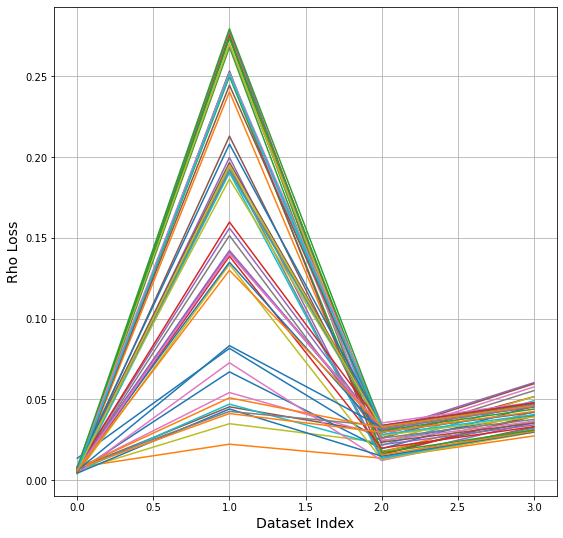

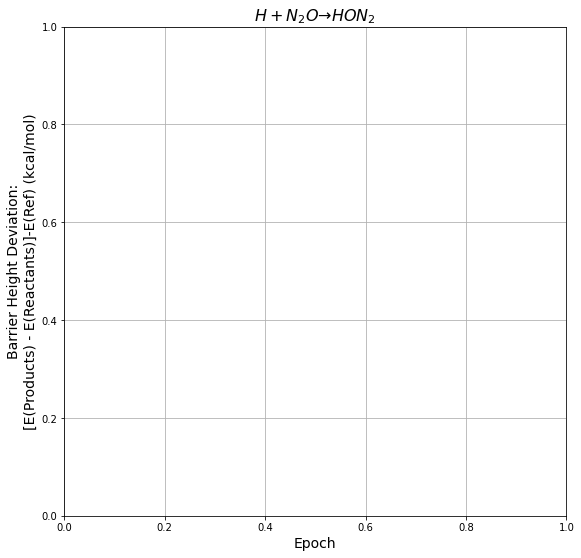

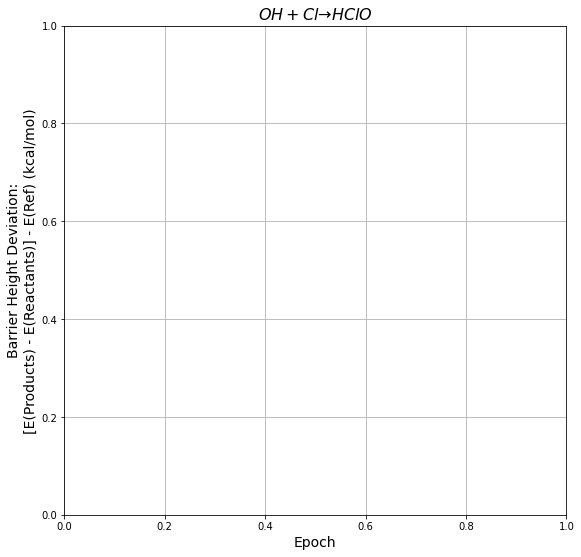

In [8]:
subd = '/home/awills/Documents/Research/swxcd/scont_aegis'
subds = ['target']

refp = '/home/awills/Documents/Research/swxcd/scont/valset/ccsdt/'
reftraj = 'results.traj'

scale = Hart_to_kcalmol
scale = Hart_to_kcalmol
refs = read(os.path.join(refp, reftraj), ':')
ref_aes = [-at.info['e_H']*scale for at in refs]
ordes = [at.calc.results['energy']*scale for at in refs]
sinds = []
sref_aes = [i[1] for i in enumerate(ref_aes) if i[0] not in sinds]
sordes = [i[1] for i in enumerate(ordes) if i[0] not in sinds]
mae=True

aerefmult = -1

mae=True
for idx in range(len(subds)):
    print(idx)
    subp = os.path.join(subd, subds[idx])
    print(subp)
    
    models = sorted([i for i in os.listdir(subp) if os.path.isdir(os.path.join(subp, i)) and 'train' not in i],
                    key = lambda x: int(x.split('_')[-1][1:]))
    print(models)
    if mae:
        cstr = 'MAE = '
    else:
        cstr = '$\sqrt{MSE} = $'
    ae_args = [
    ]
    e_args = [
    ]
    rf, rax = gen_rhoaxs()
    b1f, b1ax = gen_rhoaxs()
    b2f, b2ax = gen_rhoaxs()
    b1ax.set_xlabel('Epoch', fontsize=14)
    b1ax.set_ylabel('Barrier Height Deviation:\n[E(Products) - E(Reactants)]-E(Ref) (kcal/mol)', fontsize=14)
    b1ax.set_title('$H+N_2O \\to HON_2$', fontsize=16)
    b2ax.set_xlabel('Epoch', fontsize=14)
    b2ax.set_ylabel('Barrier Height Deviation:\n[E(Products) - E(Reactants)] - E(Ref) (kcal/mol)', fontsize=14)
    b2ax.set_title('$OH+Cl \\to HClO$', fontsize=16)
    bhs = []
    bherrs = []
    bxs = []
    
    for im, mod in enumerate(models):
        predens = []
        prederrs = []
        refens = []
        rhoerrs = []
        #column indices -- 2 = EPred, 3 = ERef, 6 = EPAtm, 7 = ERAtm, 5 = RhoErr
        #new columns indices -- 0 = index, 1 = atomformula, 2 = atomsymb, 3 = predicted energy
        mp = os.path.join(subp, mod, 'val', 'pred_e.dat')
        try:
            tab = read_eval_table_only(mp)
        except Exception as e:
            print('error opening {}'.format(mp))
            print(e)
            continue
        predtraj = read(os.path.join(subp, mod, 'val/preds/predictions.traj'),':')
        with open(os.path.join(subp, mod, 'val/atomicen.pkl'), 'rb') as f:
            predatm = pickle.load(f)
        for k,v in predatm.items():
            print(k, v)
        for aidx, at in enumerate(predtraj):
            molgen = False
            scount = 0
            while not molgen:
                try:
                    print(at)
                    name, mol = ase_atoms_to_mol(at, basis='6-311++G(3df,2pd)', spin=get_spin(at)-scount, charge=at.info.get('charge', 0))
                    molgen=True
                except RuntimeError:
                    #spin disparity somehow, try with one less until 0
                    print("RuntimeError. Trying with reduced spin.")
                    spin = get_spin(at)
                    spin = spin - scount - 1
                    scount += 1
                    if spin < 0:
                        raise ValueError
            _, method = gen_mf_mol(mol, xc='notnull', pol=True, grid_level=5, nxc=True)
            mf = UKS(mol)
            mf.grids.level = 5
            mf.grids.build()
            ao_eval = mf._numint.eval_ao(mol, mf.grids.coords)
            
            dm_pred = np.load(os.path.join(subp, mod, 'val/preds/{}_{}.dm.npy'.format(aidx, at.symbols)))
            dm_ref = np.load(os.path.join(refp, '{}_{}.dm.npy'.format(aidx, at.symbols)))
            mocc_ref = np.load(os.path.join(refp, '{}_{}.mo_occ.npy'.format(aidx, at.symbols)))
            print("SHAPES")
            print("ao_eval: ", ao_eval.shape)
            print("dm_pred: ", dm_pred.shape)
            print("dm_ref: ", dm_ref.shape)
            
            rho_pred = dm_to_rho(dm_pred, ao_eval)
            rho_ref = dm_to_rho(dm_ref, ao_eval)
            
            
            nelec = mol.nelec
            
            rho_err = rho_dev(dm_pred, nelec, rho_pred, rho_ref, mf.grids.weights, mocc_ref)
            rhoerrs.append(rho_err)
            
            err = False
            #barriers start at index 8; 8+9=10, 11+12=13
            print(idx, at)
            print(at.info)
            syms = ''.join(at.get_chemical_symbols())
            ats = split(syms)
            print(ats)
            print("----------------------------------")
            bhstartind = 1000
            bhprodsinds = []
            if aidx < bhstartind:
                refen = -scale*predtraj[aidx].info.get('e_H', None)
                refens.append(refen)
                try:
                    pred_e = scale*at.info['e_pred']
                except:
                    err = True
                    print('error occured -- e_pred not in predictions.traj')
                    break
                for s in ats:
                    print(syms, s)
                    pred_e -= scale*predatm[s]
                print('ae en: {}'.format(pred_e))
                print('ref en: {}'.format(refen))
                print('abs err: {}'.format(abs(pred_e-refen)))
                print('rho err: {}'.format(rho_err))
                predens.append(pred_e)
                print("==================================")
            elif aidx in bhprodinds:
                refen = scale*predtraj[aidx].info.get('bh_ref', None)
                refens.append(refen)
                pred_e = scale*at.info['e_pred']
                pred_e += - (scale*predtraj[aidx - 1].info['e_pred'] + scale*predtraj[aidx - 2].info['e_pred'])

                print('bh en: {}'.format(pred_e))
                print('ref en: {}'.format(refen))
                print('abs err: {}'.format(abs(pred_e-refen)))
                print('rho err: {}'.format(rho_err))
                predens.append(pred_e)
                print("==================================")
        if err:
            print("Error in loop -- skipping model")
            continue

        #aey = scale*(tab.iloc[g2inds, 6].astype(np.float64))
#         predey = scale*np.array([i.info['energy'] for i in predtraj][g2inds])
#         aeref = -scale*np.array([i.info['atomization'] for i in predtraj[g2inds]])
#         aeerr = scale*(tab.iloc[g2inds, 6].astype(np.float64) - aerefmult*tab.iloc[g2inds, 7].astype(np.float64))
#         aee = np.mean(np.abs(aeerr))
#         ey = scale*(tab.iloc[:, 2].astype(np.float64))
#         eerr = scale*(tab.iloc[:, 2].astype(np.float64) - tab.iloc[:, 3].astype(np.float64))
#         ee = np.mean(np.abs(eerr))
        ey = scale*np.array([at.info['e_pred'] for at in predtraj])
        aey = predens[:-2]
        ry = rhoerrs
        re = np.mean(np.abs(ry))
        bh = predens[-2:]
        bherr = np.array(bh) - np.array(refens[-2:])
        bhs.append(bh)
        bherrs.append(bherrs)
        bxs.append(int(mod.split('_')[-1][1:]))
        print("BHS: ", bhs)
        if mae:
            cstr = 'MAE = '
            re = np.mean(np.abs(rhoerrs))
            aee = np.mean(np.abs(np.array(predens[:-2]) - np.array(refens[:-2])))
#             aee = np.mean(np.abs(np.array(predens[-2:]) - np.array(refens[-2:])))
            ee = np.mean(scale*np.abs([at.info['e_pred'] - at.calc.results['energy'] for at in predtraj]))
        else:
            cstr = '$\sqrt{MSE} = $'
            re = 0
            aee = 0
            ee = 0
        
        rax.plot(ry, label='{}: '.format(mod)+cstr+"{:4.3f}".format(re))
        
        ae_args.append( (aey, '{}: '.format(mod)+cstr+"{:4.3f}".format(aee)) )
        e_args.append( (ey, '{}: '.format(mod)+cstr+"{:4.3f}".format(ee)) )
    
    
    bhs = np.array(bhs)
    b1ax.plot(bxs, scale*(xcdbhv[0]*np.ones_like(bxs))-ref_bhs[0], 'k-', label='XCDiff Deviation')
    b1ax.plot(bxs, (bhs[:, 0])-ref_bhs[0], '-', label='Predicted Deviation')
    b2ax.plot(bxs, scale*(xcdbhv[1]*np.ones_like(bxs))-ref_bhs[1], 'k--', label='XCDiff Deviation')
    b2ax.plot(bxs, (bhs[:, 1])-ref_bhs[1], '--', label='Predicted Deviation')
    b1ax.legend()
    b2ax.legend()
    b1f.tight_layout()
    b2f.tight_layout()
    
    b1f.savefig(os.path.join(sebp, '{}_valloss_bh1.png'.format(sebds[idx])))
    b2f.savefig(os.path.join(sebp, '{}_valloss_bh2.png'.format(sebds[idx])))
    
    rax.legend()
    rf.tight_layout()
    rf.savefig(os.path.join(sebp, '{}_valloss_rho.png'.format(sebds[idx])))
    
    f, eax, edax, dax, ddax = gen_pltaxs(figsize=(20,20), scale=scale)
    plot_e_dev(enax=eax, endax=edax, refs=np.array(ref_aes), reflabel='Validation Dataset Atomization', datlist=ae_args)
    plot_e_dev(enax=dax, endax=ddax, refs=np.array(ordes), reflabel='Validation Dataset CCSD(T)', datlist=e_args)
    eax.legend(ncol=1)
    #edax.legend()
    dax.legend(ncol=1)
    #ddax.legend()
    if scale == Hart_to_kcalmol:
        units = 'kcal/mol'
    else:
        units = 'H'

    for imdx, at in enumerate(refs):
        ddax.annotate(at.symbols, (imdx, e_args[0][0].values[imdx]-ordes[imdx]), (imdx+0.5, e_args[0][0].values[imdx]-ordes[imdx]),
                        backgroundcolor="#bebebe", alpha=1, arrowprops={'width':1})

    f.tight_layout()
    f.savefig(os.path.join(sebp, '{}_valloss_epochs.png'.format(sebds[idx])))

    
    sae = [ae_args[0]]+[ae_args[-1]]
    se = [e_args[0]] + [e_args[-1]]
    f, eax, edax, dax, ddax = gen_pltaxs(figsize=(20,20), scale=scale)
    plot_e_dev(enax=eax, endax=edax, refs=np.array(ref_aes), reflabel='Validation Dataset Atomization', datlist=sae)
    plot_e_dev(enax=dax, endax=ddax, refs=np.array(ordes), reflabel='Validation Dataset CCSD(T)', datlist=se)
    eax.legend(ncol=1)
    #edax.legend()
    dax.legend(ncol=1)
    #ddax.legend()
    if scale == Hart_to_kcalmol:
        units = 'kcal/mol'
    else:
        units = 'H'

    for imdx, at in enumerate(refs):
        ddax.annotate(at.symbols, (imdx, e_args[0][0].values[imdx]-ordes[imdx]), (imdx+0.5, e_args[0][0].values[imdx]-ordes[imdx]),
                        backgroundcolor="#bebebe", alpha=1, arrowprops={'width':1})

    plt.tight_layout()
    plt.savefig(os.path.join(sebp, '{}_valloss_last.png'.format(sebds[idx])))


In [9]:
read_table_only?

Object `read_table_only` not found.


In [88]:
def atomization_energy(totalenergy, molsym, atoms, atome):
    print(molsym, totalenergy)
    for idx, at in enumerate(atoms):
        totalenergy -= atome[at]
    print(totalenergy)
    return totalenergy

ref_ae_mult = -1
ref_ae_traj = read('/home/awills/Documents/Research/swxcd/scont/valset/val.traj', ':')
ref_ae_dct = {str(at.symbols):ref_ae_mult*at.info['e_H'] for at in ae_ref_traj}
ae_abse_cat = {k: [] for k in ref_ae_dct.keys()}
ae_sqe_cat = {k: [] for k in ref_ae_dct.keys()}

base_pred_dir = '/home/awills/Documents/Research/swxcd/scont_aegis/target/'
models = sorted([i for i in os.listdir(base_pred_dir) if 'MODEL' in i], key= lambda x: x.split('_')[-1][1:])
epochs = sorted([int(i.split('_')[-1][1:]) for i in models])
mod_pred_dir = 'val'
ind_pred_dir = 'preds'
pred_traj = 'predictions.traj'
atom_pred = 'atomicen.dat'
mol_pred = 'pred_e.dat'
for idx, model in enumerate(models):
    atome = read_eval_table_only(os.path.join(base_pred_dir, model, mod_pred_dir, atom_pred))
    mole = read_eval_table_only(os.path.join(base_pred_dir, model, mod_pred_dir, mol_pred))
    predtraj = read(os.path.join(base_pred_dir, model, mod_pred_dir, ind_pred_dir, pred_traj), ':')
    traj_symb = {str(i.symbols) : i.get_chemical_symbols() for i in predtraj}
    atom_dict = {i['#Atom']: i['Energy (Hartree)'] for idx, i in atome.iterrows()}
    mole['symsplit'] = [traj_symb[i] for i in mole['AtomSymb'].values]

    pred_ae_dct = {}
    for idx, row in mole.iterrows():
        ae = atomization_energy(molsym=row['AtomSymb'], totalenergy=row['Predicted Energy (Hartree)'], atoms=row['symsplit'],
                          atome=atom_dict)
        pred_ae_dct[row['AtomSymb']] = ae

    ae_abse_dct = {k: abs(ref_ae_dct[k] - pred_ae_dct[k]) for k in ref_ae_dct.keys()}
    ae_sqe_dct = {k: (ref_ae_dct[k]-pred_ae_dct[k])**2 for k in ref_ae_dct.keys()}
    for k in ref_ae_dct.keys():
        ae_abse_cat[k].append(ae_abse_dct[k])
        ae_sqe_cat[k].append(ae_sqe_dct[k])

LiH -7.922679590500377
-0.07937599170268411
NO -128.9555687459895
-0.26649715955467457
C2H2 -76.61899812400819
-0.6494698930128884
BF3 -322.38182944536766
-0.7487252057865135
LiH -7.985484126797817
-0.08516377609769166
NO -129.23152900416628
-0.2549670240413633
C2H2 -76.8500096135317
-0.6339906374185739
BF3 -322.96439404372313
-0.7073413463005238
LiH -8.050059873682041
-0.09068246793860463
NO -129.50991271065848
-0.24500839965739374
C2H2 -77.08355766801026
-0.6190728329785338
BF3 -323.5511349803161
-0.6645874029144068
LiH -8.095399915748947
-0.09362625532086333
NO -129.72160607892434
-0.23980657202203304
C2H2 -77.2579352786357
-0.6105560831381402
BF3 -324.0026966016547
-0.6397117696061798
LiH -8.118285716375166
-0.09512818465639339
NO -129.84411086984105
-0.23899934901581332
C2H2 -77.35613305401534
-0.6089642008540914
BF3 -324.2691518712561
-0.6324979932525423
LiH -8.118204537384388
-0.09540058528570894
NO -129.8664014931022
-0.24155245076286747
C2H2 -77.37046399018249
-0.6130367185416

C2H2 -77.3708607664646
-0.7448311364389375
BF3 -324.7762798829889
-0.8792085301440693
LiH -8.042457167225452
-0.09595333551955787
NO -129.9801556292197
-0.3482987114016396
C2H2 -77.37187920993124
-0.7441417848454823
BF3 -324.779239413196
-0.8787452778809381
LiH -8.040876644823282
-0.09587278335000288
NO -129.97533964611384
-0.34897007652240575
C2H2 -77.36731315830303
-0.7446895229909942
BF3 -324.7701897330146
-0.8807544108434229
LiH -8.04154544164711
-0.09585489561327959
NO -129.97834155407156
-0.3486946912795901
C2H2 -77.36981003673004
-0.7443206289617379
BF3 -324.7764742251249
-0.8801819241144813
LiH -8.041006205651431
-0.09580225778951651
NO -129.97646864624753
-0.348751942466194
C2H2 -77.36807405480056
-0.7442606020435014
BF3 -324.7727432785577
-0.8806236496206168


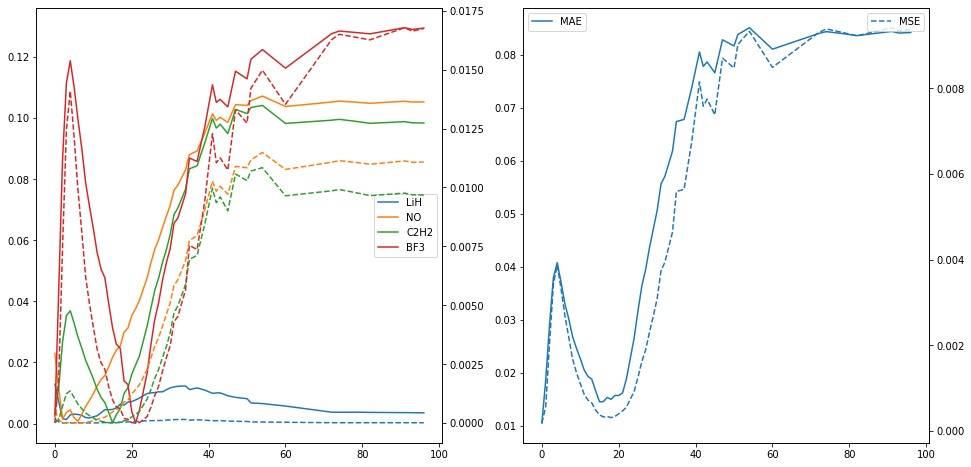

In [111]:
f = plt.figure(figsize=(16,8))
axae = f.add_subplot(121)
axse = axae.twinx()

axmae = f.add_subplot(122)
axmse = axmae.twinx()

for k in ref_ae_dct.keys():
    axae.plot(epochs, ae_abse_cat[k], label=k)
    axse.plot(epochs, ae_sqe_cat[k], ls='--')
axae.legend()

abse_arr = np.array([ae_abse_cat[k] for k in ref_ae_dct.keys()]).T
sqe_arr = np.array([ae_sqe_cat[k] for k in ref_ae_dct.keys()]).T

axmae.plot(epochs, abse_arr.mean(axis=1), label='MAE')
axmse.plot(epochs, sqe_arr.mean(axis=1), ls='--', label='MSE')
axmae.legend(loc='upper left')
axmse.legend(loc='upper right')

In [113]:
xcp = '/home/awills/Documents/Research/swxcd/scont_aegis/target/MODEL_GGA_e1001/xc'
model = torch.load(xcp)

In [123]:
model.xc.eval_grid_models??

In [122]:
model.xc.grid_models??